# **Exercise 1: Logistic Regression via Gradient Ascent**
Tictactoe dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.random import seed
seed(seed=3116)
import math
from IPython.display import display, Image

In [ ]:
tictactoe = pd.read_csv("https://raw.githubusercontent.com/Can-Berk/Machine_Learning_Labs/main/Datasets/tic-tac-toe.data",delimiter=',',header=None)
tictactoe.head()

,0,1,2,3,4,5,6,7,8,9
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [ ]:
colnames=['top-left-square','top-middle-square','top-right-square','middle-left-square','middle-middle-square','middle-right-square','bottom-left-square','bottom-middle-square','bottom-right-square','Class']
tictactoe.columns=colnames
tictactoe.head()

,top-left-square,top-middle-square,top-right-square,middle-left-square,middle-middle-square,middle-right-square,bottom-left-square,bottom-middle-square,bottom-right-square,Class
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [ ]:
tictactoe['Class'][tictactoe['Class'] == "positive"] = 1
tictactoe['Class'][tictactoe['Class'] == "negative"] = 0

In [ ]:
tictactoe = tictactoe.astype('category')
tictactoe_hotone = pd.get_dummies(tictactoe, sparse=True)
tictactoe_hotone.head()

,top-left-square_b,top-left-square_o,top-left-square_x,top-middle-square_b,top-middle-square_o,top-middle-square_x,top-right-square_b,top-right-square_o,top-right-square_x,middle-left-square_b,...,bottom-left-square_o,bottom-left-square_x,bottom-middle-square_b,bottom-middle-square_o,bottom-middle-square_x,bottom-right-square_b,bottom-right-square_o,bottom-right-square_x,Class_0,Class_1
0,0,0,1,0,0,1,0,0,1,0,...,0,1,0,1,0,0,1,0,0,1
1,0,0,1,0,0,1,0,0,1,0,...,1,0,0,0,1,0,1,0,0,1
2,0,0,1,0,0,1,0,0,1,0,...,1,0,0,1,0,0,0,1,0,1
3,0,0,1,0,0,1,0,0,1,0,...,1,0,1,0,0,1,0,0,0,1
4,0,0,1,0,0,1,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1


In [ ]:
tictactoe_hotone['Class']=tictactoe['Class']
tictactoe_hotone=tictactoe_hotone.drop(['Class_0',"Class_1"], axis=1)

In [ ]:
tictactoe_hotone.groupby('Class').size()

Class
0    332
1    626
dtype: int64

In [ ]:
df = tictactoe_hotone

In [ ]:
def stratified_sample(df, fraction:float):
    random_groups = df.groupby("Class").apply(lambda group: group.sample(frac = fraction, random_state=3116))
    random_x_nots = random_groups.loc[0]
    random_xs = random_groups.loc[1]
    return pd.concat([random_x_nots, random_xs]).sample(frac = 1, random_state = 3116)

In [ ]:
df_train = stratified_sample(df, 0.8)
df_test = df.drop(df_train.index)

In [ ]:
df_train.shape

(767, 28)

In [ ]:
#print(f"Trainig data x wins {len(df_train["Class"][df_train["Class"]==1])/len(df_train)*100}% cases")

In [ ]:
len(df_train["Class"][df_train["Class"]==1])/len(df_train)*100

65.31942633637549

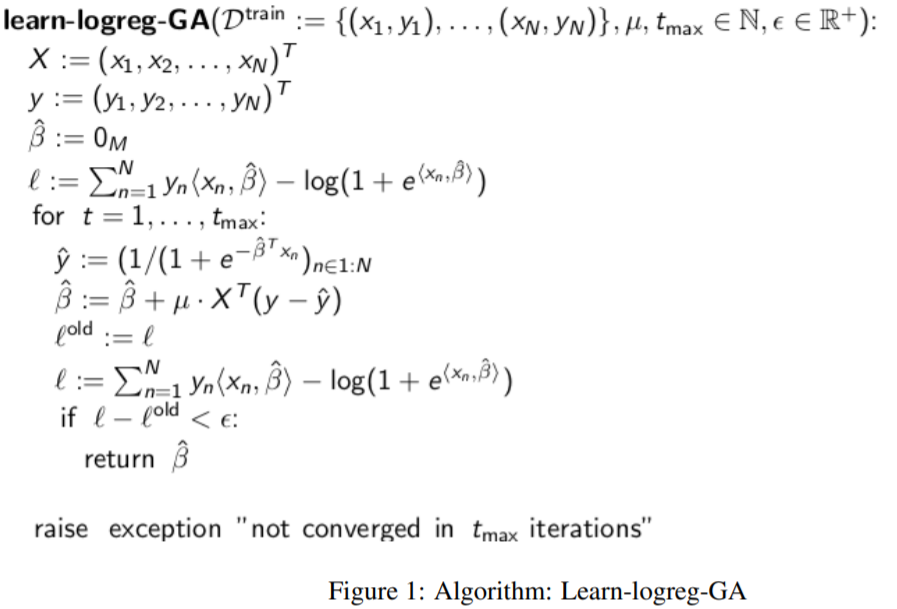

In [ ]:
Image(filename = "Log_reg_GA.PNG", width=450, height=300)

In [ ]:
def sigmoid(x):
    return 1/(1+np.e**(-x))
    
def log_likelihood(X,Y,B):
    return Y.T@X@B +np.sum(-np.log(1+np.e**(X@B)))
    
def log_likelihood_db(X,Y,B):
    return X.T@(Y-sigmoid(X@B))
    
def steplenght_bolddriver(f,x,dx,u_old):
    u_plus = 1.05
    u_minus = 0.5
    u= u_old*u_plus
    while f(x)-f(x+u*dx)>0:
        u=u_old*u_minus
    return u

In [ ]:
def learn_logreg_SGD(df_train,df_test, u, imax):
    X_train = df_train.drop("Class", axis=1).to_numpy()
    Y_train = df_train["Class"].to_numpy()
    X_test = df_test.drop("Class", axis=1).to_numpy()
    Y_test = df_test["Class"].to_numpy()
    #n,m
    B=np.zeros(len(X_train[1]))
    l = log_likelihood(X_train, Y_train, B)
    
    err = np.empty(imax)
    log_loss = np.empty(imax)
    
    for t in range(imax):             #calculated
        dB = log_likelihood_db(X_train, Y_train, B)
        u = steplenght_bolddriver(lambda B: log_likelihood(X_train, Y_train, B), B, dB, u)
        
        for x,y in zip(X_train, Y_train):    #sgd
            y_pred = sigmoid(B.T@x)
            B += u*(y-y_pred)*x

            
        l_old= l
        l= log_likelihood(X_train, Y_train, B)
        err[t] = np.abs(l_old - l)
        log_loss[t] = -log_likelihood(X_test,Y_test, B)
        
    return B, err, log_loss

In [ ]:
B, err, log_loss = learn_logreg_SGD(df_train, df_test, 0.001, 300)

In [ ]:
log_loss

array([122.64597608, 118.03316968, 115.07950415, 112.76059385,
       110.77075729, 109.00965657, 107.43429971, 106.01762568,
       104.73757886, 103.57449164, 102.51053251, 101.52958266,
       100.61716171,  99.76033623,  98.94761056,  98.16880867,
        97.41495422,  96.67815353,  95.95148405,  95.22889011,
        94.50508667,  93.77547114,  93.03604336,  92.28333353,
        91.51433762,  90.72646005,  89.91746337,  89.08542443,
        88.22869689,  87.34587964,  86.43579076,  85.49744667,
        84.53004589,  83.53295704,  82.50571043,  81.44799274,
        80.35964432,  79.2406584 ,  78.09118192,  76.91151752,
        76.22136248,  75.61313101,  74.99386605,  74.35309155,
        73.68880349,  73.00047832,  72.28791814,  71.55101449,
        70.78970348,  70.00396131,  69.19380857,  68.35931655,
        67.50061438,  66.61789626,  65.71142877,  64.78155788,
        64.23179482,  63.75208335,  63.26453924,  62.76026104,
        62.23756128,  61.69601645,  61.13547785,  60.55

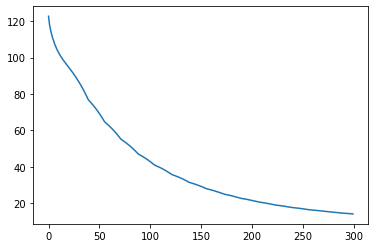

In [ ]:
plt.plot(log_loss)
plt.show()

# **Exercise 2: Implement Newton Algorithm for Logistic Regression**

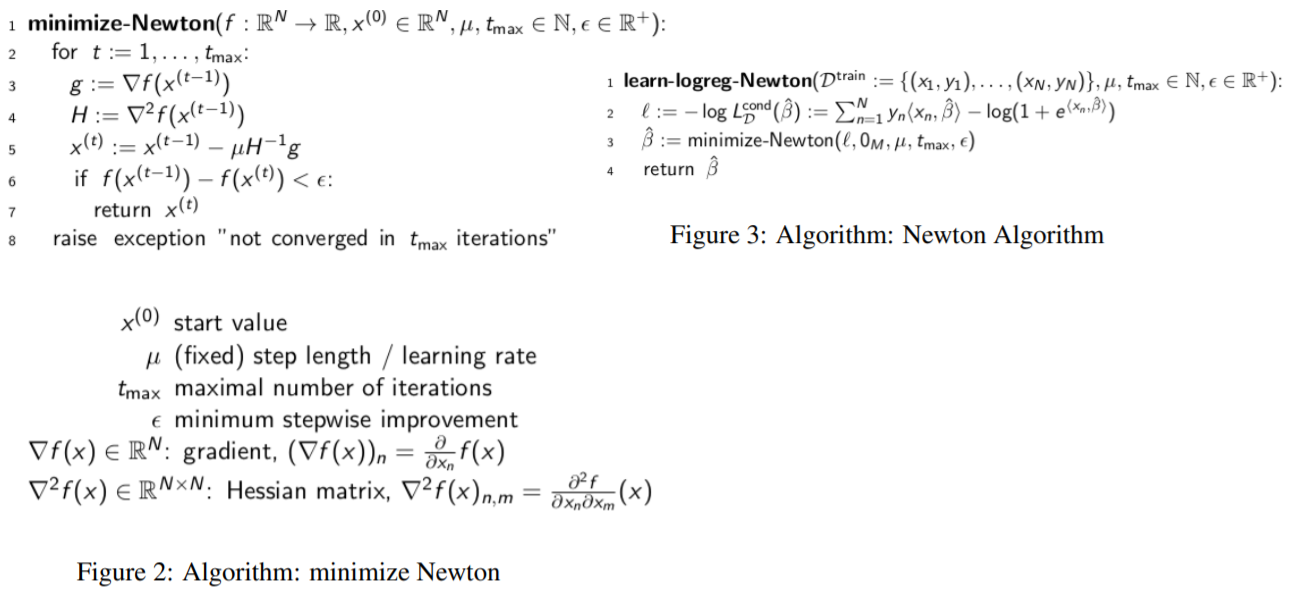

In [ ]:
Image(filename = "Log_reg_Newton.PNG", width=700, height=400)

In [ ]:
def learn_logreg_Newton(df_train,df_test, u, imax):
    X_train = df_train.drop("Class", axis=1).to_numpy()
    Y_train = df_train["Class"].to_numpy()
    X_test = df_test.drop("Class", axis=1).to_numpy()
    Y_test = df_test["Class"].to_numpy()
    #n,m
    B=np.zeros(len(X_train.T))
    l = log_likelihood(X_train, Y_train, B)
    
    err = np.empty(imax)
    log_loss = np.empty(imax)
    
    for t in range(imax):
        y_pred = sigmoid(X_train@B)
        W = np.diag(y_pred*(1-y_pred))

        B += u*np.linalg.pinv(X_train.T@W@X_train)@X_train.T@(Y_train-y_pred)
        
        l_old = l
        l = log_likelihood(X_train, Y_train, B)
        err[t] = np.abs(l-l_old)
        log_loss[t] = -log_likelihood(X_test, Y_test, B)
    
    return B, err, log_loss

In [ ]:
B, err, log_loss = learn_logreg_Newton(df_train, df_test, 1, 300)

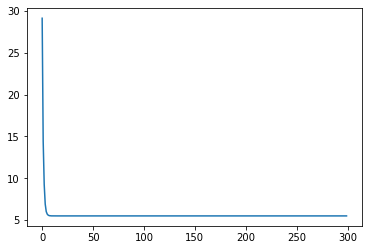

In [ ]:
plt.plot(log_loss)
plt.show()

In [ ]:
log_loss[-1]

5.5122538417772375